<a href="https://colab.research.google.com/github/heosooyoun/LLM/blob/main/chap_4_1%EC%97%90%EC%84%9C_4_2_%EC%A0%95%EA%B7%9C%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장. 밑바닥부터 GPT 모델 구현하기

In [39]:
from importlib.metadata import version

print("맷플롯립 버전:", version("matplotlib"))
print("파이토치 버전:", version("torch"))
print("tiktoken 버전:", version("tiktoken"))

맷플롯립 버전: 3.10.0
파이토치 버전: 2.8.0+cu126
tiktoken 버전: 0.12.0


### 4.1 구조 구현하기

- 1장은 GPT와 Llama 같은 모델을 소개했습니다. 이런 모델은 원본 트랜스포머 구조의 디코더 부분을 기반으로 순차적으로 단어를 생성합니다.
- 따라서 이런 LLM을 종종 디코더 기반 LLM이라 부릅니다.
- 전통적인 딥러닝 모델과 비교하면 LLM은 규모가 큽니다. 이는 코드의 양이 아니라 방대한 파라미터 개수 때문입니다.
[링크 텍스트](https://)
-> 모델 파라미터 갯수나 훈련 데이터 등 사용하는 데이터가 많다는 의미
- 앞으로 보겠지만 LLM 구조의 많은 구성 요소가 반복적입니다.

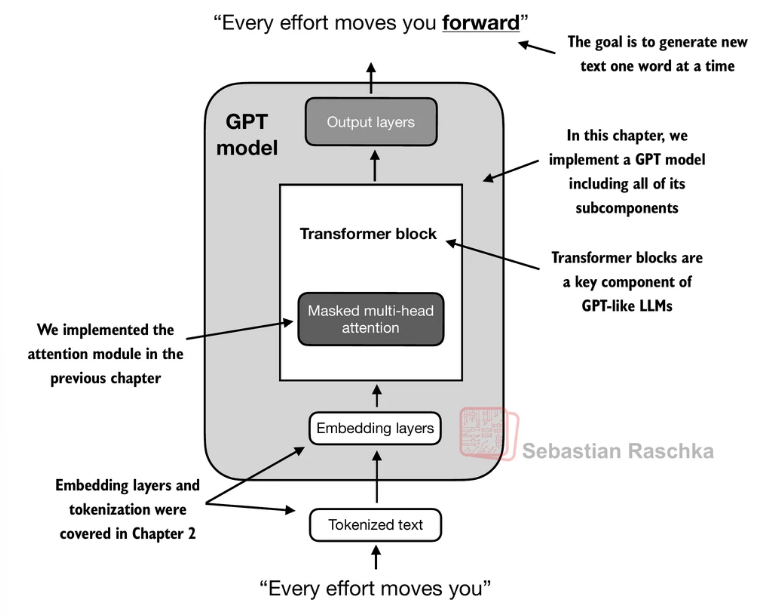

- 토크나이저: 토큰화 및 토큰 ID 부여
- 임베딩층: 토큰 아이디, 정수 아이디를 고정된 크기의 실수 벡터로 바꿔줌
- 디코더 블록: 입력과 출력의 크기가 같기 때문에 연달아 사용 가능
- 출력층을 통과해서 텍스트로 만들어줌
=> 여기까지가 GPT(LLM) 모델의 역할
- 출력층의 결과를 텍스트로 만들어 주는 것은 LLM의 역할이 아님

In [40]:
#GPT-2 모델의 파라미터를 따라함
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘사전 크기
    "context_length": 1024, # 문맥 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 개수
    "n_layers": 12,         # 층 개수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리, 키, 값을 만들 때 편향 포함 여부
}

- 대부분 설정 파일은 밖에 빼놓음
-> 설정 내용을 사용하여 만드는 모델(모델 클래스)는 동일 하다는 의미

In [41]:
#GPT 모델의 뼈대 먼저 구현

import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 토큰임베딩, 위치 임베딩 객체
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        # 트랜스포머 블록
        # cfg : 위에 선언된 옵션의 값들
        # DummyTransformerBlock 클래스 객체를 12개 만들기
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        # 층 정규화
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # 최종 출력 층
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds # 입력
        x = self.drop_emb(x)
        x = self.trf_blocks(x) # 더미 트랜스포머 블록이 12번
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits # 활성함수를 통과하지 않은 값을 logits이라고 부


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 더미 클래스

    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환합니다.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 층 정규화 인터페이스를 흉내내기 위한 매개변수

    def forward(self, x):
        # 이 블록은 아무것도 하지 않고 입력을 그냥 반환합니다.
        return x

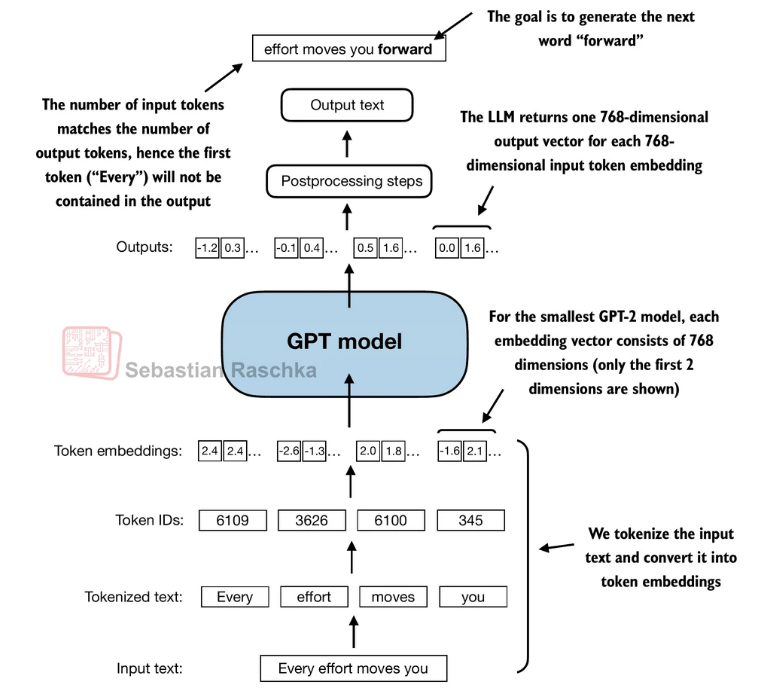

아래부터 차례대로
- 토크나이저: 입력 텍스트를 토큰화 한 후 토큰 아이디로 바꿈
- 임베딩층: 토큰 아이디를 토큰 임베딩으로 바꿈(768개)(여기부터 llm층의 역할)
- 결과도 768차원
- 최종 리니어 층 + 또 다른 구성요소: 텍스트로 변환


In [42]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1))) #토큰화
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch) #텐서 만들기

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [43]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M) # gpt모델 객체 만들기

logits = model(batch) # 입력 데이터 넣기
print("출력 크기:", logits.shape)
print(logits)
# [2, 4, 50257] 해석
# 두개의 시퀸스가 들어가서 2
# 각 샘플에 4개의 토큰이라 4
#각 출력 벡터 크기 50257 == 리니어층의 출력 크기
# 선형층에서 768(출력 벡터 크기)을 50257로 바꾼 것

출력 크기: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


### 4.2 층 정규화로 활성화 정규화하기

- 배치 정규화: 여러 샘플의 한 특성을 정규화 하는 것

- 층 정규화: 각 입력 샘플 == 각 토큰의 임베딩 벡터(각 토큰의 특성)을 정규화
- 정규화 == 표준화: 각 값에서 평균을 뺀 제곱을 갯수로 나누는 것

->  평균이 0이고 분산이 1이 되도록 조정하는 것

=> 스케일을 비슷하게 맞추는 것

- 층 정규화는 트랜스포머 블록의 멀티 헤드 어텐션 모듈 전후에 적용됩니다. 또한 최종 출력 층 전에도 적용

In [45]:
torch.manual_seed(123)

# 다섯 개의 차원(특성)을 가진 두 개의 훈련 샘플을 만듭니다.
batch_example = torch.randn(2, 5) #행이 2개, 열이 5개


layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)
print()

# 두 개의 입력에 대해 각각 평균과 분산을 계산
#dim=-1의 의미: 마지막 차원을 따라 평균과 분산을 계산한다는 의미
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("평균:\n", mean)
print("분산:\n", var)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

평균:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
분산:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- dim이 -1이면 각 행의 열을 따라서 평균을 계산
  - 마지막 차원을 -1로 찾는 이유는 각 마지막 차원을 1,2,3 이렇게 찾기보단 -1을 이용해 그런거 상관 없이 바로 마지막 차원을 찾을 수 있기 때문
- dim이 0이면 각 열을 따라 특성별로 계산

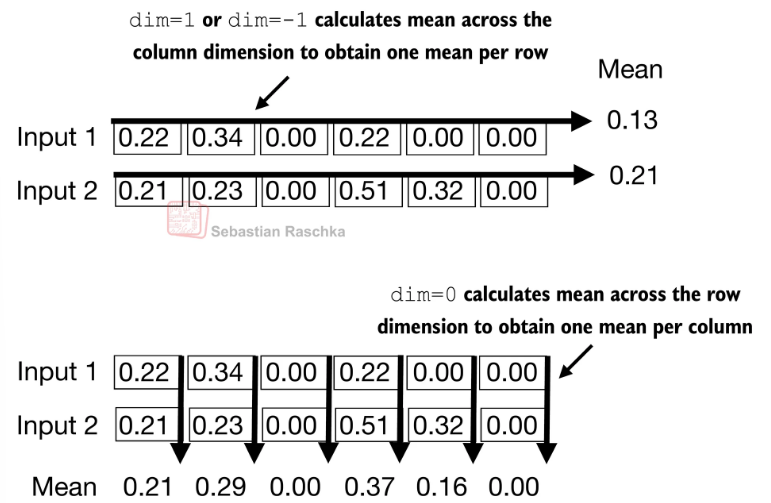

In [46]:
#표준화 or 정규화 하기

#표준화 공식
out_norm = (out - mean) / torch.sqrt(var)
print("정규화된 층 출력:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("평균:\n", mean)
print("분산:\n", var)

정규화된 층 출력:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
평균:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [47]:
# 지수를 지우기 위한 평균, 분산을 다시 계산

torch.set_printoptions(sci_mode=False)
print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [48]:

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # 스케일 값을 임베딩 차원 갯수만큼 만들고 있음
        self.scale = nn.Parameter(torch.ones(emb_dim)) # 1로 초기화
        self.shift = nn.Parameter(torch.zeros(emb_dim)) #0으로 초기화

    def forward(self, x): # 정규화
        mean = x.mean(dim=-1, keepdim=True) # 평균
        var = x.var(dim=-1, keepdim=True, unbiased=False) # 분산
        # correction=0과 unbiased=False는 동일

        # self.eps 값: 분산이 너무 작거나 0이 되면 결과값이 오버플로우 될 수 있기 때문에
        # 적당히 작은 값을 더해줌 == 이 값을 입실론이라고 함
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        # 선형 변환을 하는 것 처럼 가중치를 곱하고 편향을 더하는 것처럼 작업
        # 어떤 층의 출력을 평균이 0, 분산이 1이 되도록 너무 획일적으로 바꾸면
        # 층이 학습해서 내놓은 특성이 다 똑같아 질 수 있기 때문에
        # 정규화 된 출력에 스케일을 곱하고 편향 shift를 더해주는 것
        return self.scale * norm_x + self.shift

In [49]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

#위에서 scale과 shoft가 0과 1로 초기화 되었기 때문에 실제로 동작에 의미가 없어짐

print("평균:\n", mean)
print("분산:\n", var)

평균:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
분산:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### 층 정규화는 배치 정규화와 같은 부분인데 LLM(== 시퀀스 데이터)에 적용하기 위해 각 토큰별로 적용하는 방법이다